In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Dataset**

The ‘TennisAbstract’ website and its associated blog ‘Heavy Topspin’ are resources made available for free by tennis enthusiast Jeff Sackmann. The source is widely referenced in both academic papers (Kovalchik Stephanie, 2016) and in less formal analyses by members of the tennis community and is regularly maintained. The raw data that they link to contains 
information on all ATP tournaments going all the way back to 1968.

In [138]:
''' 

Function to import data from github. Date range must be valid per the given URL

'''

def import_data(start_date: int, end_date: int):
    li = []
    for year in range(start_date, end_date, 1):
        url = f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/refs/heads/master/atp_matches_{year}.csv'
        data = pd.read_csv(url, header=0)

        li.append(data)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame


df = import_data(2010, 2019)
print('Shape:', df.shape)
df.head(5)

Shape: (26591, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,20100103,1,104053,1.0,NaN,...,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,20100103,2,104958,NaN,WC,...,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,20100103,3,104755,NaN,NaN,...,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0
3,2010-339,Brisbane,Hard,32,A,20100103,4,105051,NaN,Q,...,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0
4,2010-339,Brisbane,Hard,32,A,20100103,5,104607,4.0,NaN,...,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0


**Basic data cleaning**

The following actions were taken to clean the data ahead of analysis:

•   Dates were standardized using the datetime package.

•   Matches with empty data fields were removed.

•   Abandoned matches were removed by deleting games with fewer than 24 service points from winner and loser.

•   Matches with missing ‘handedness’ were removed

•   Missing height data was replaced with average height for winner / loser. This is clearly a large assumption but with so many players not having any height data the alternative was to remove them all and it was felt that this would remove too much valuable information from the dataset.

•   Players with missing age data were removed.

•   Players without rank data were removed.

•   Matches with no surface data were removed

•   Players who had played less than 5 games at ATP level during the study were removed. This was done to address the fact that many of the players on the ATP tour are on the fringes of this level of the game. Places at local tournaments are often secured for local players who are not up to the standard of the other competitors. Players in this category are outliers in the sense that they only manage a handful of games at this level throughout their careers and therefore there is limited data on each of them to have a meaningful impact on a predictive model. The removal of players with fewer than 5 competitive matches at this level over the period of the data is qualitative attempt to ‘clean’ the data of these contributions. 
 


In [139]:
'''

Perform data 'cleaning' operations on raw dataframe. List of transformations can be found 
in the precedint markdown cell but in general the goal is to homogenise the dataframe with a 
goal of modelling contests with similar characteristics

'''


def clean_data(df):
    ### Reformat dates using datetime
    df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
    ### Restrict analysis to hard courts 
    df = df[df['surface'] == 'Hard']
    ### Remove matches with significant missing data (use 'winner aces' here but could use any of missing fields)
    df = df.dropna(subset=['w_ace'])
    ### Remove abandoned matches - fewer than 24 serves.
    df = df[df['w_svpt'].gt(24) | df['l_svpt'].gt(24)]
    ### Remove matches where 'handedness of one or other players is missing or n/a
    df = df.dropna(subset=['winner_hand', 'loser_hand'])
    ### Replace missing height data with average height
    df['loser_ht'] = df['loser_ht'].fillna(df['loser_ht'].mean())
    df['winner_ht'] = df['winner_ht'].fillna(df['winner_ht'].mean())
    ### Remove entries with missing rank data
    df = df.dropna(subset=['winner_rank', 'loser_rank'])
    ### Replace winner/loser structure with a player1/player2 structure
    df['flag'] = np.random.randint(0, 2, df.shape[0])
    df['Player1'] = np.where(df['flag'] == 1, df['winner_name'], df['loser_name'])
    df['Player2'] = np.where(df['flag'] == 1, df['loser_name'], df['winner_name'])
    
    return df

df = clean_data(df)

**Calculate player stats database**\
Re orient the data from the Tennis Abstract website so that we can calculate historic rolling averages for the stats:

In [140]:
'''

Build a dataframe of player statistics based only on past matches and summarising performandce stats
over a given time window. Also tidy up the remaining fields and impute missing values for match length data.

'''

match_info = df.columns[np.r_[0:7, 23:27]]
winner_info = df.columns[np.r_[7:15, 27:36, 45, 46]]
loser_info = df.columns[np.r_[15:23, 36:45, 47, 48]]


w = df[winner_info]
l = df[loser_info]

def create_players_df(a, b):
    a.columns = [x[1] for x in a.columns.str.split('_')]
    b.columns = [x[1] for x in b.columns.str.split('_')]
    a = pd.concat([df[match_info], a], axis=1)
    b = pd.concat([df[match_info], b], axis=1)

    players_df = pd.concat([a, b])
    return players_df

p_df = create_players_df(w, l)

### Remove seed / entry columns as they're useless & missing lots of data
p_df.drop(['seed', 'entry'], axis=1, inplace=True)

### Rename last column as we have rank & rank
p_df.columns = [*p_df.columns[:-1], 'rank points'] 

# replace missing match length with average match length
p_df['minutes'] = p_df['minutes'].fillna(p_df['minutes'].mean())

### Set index in both dataframes as 'tourney date'
df = df.set_index('tourney_date')
p_df = p_df.set_index('tourney_date')
p_df.index.name = 'MyDate'
p_df = p_df.sort_values(by=['name', 'MyDate'], ascending=[True, True])
 

**Infrequent competitors**

Now consider players who've not played many times over the relevant period...

In [141]:
### Create df of players with their win totals
def player_record(df):
    players = np.union1d(pd.unique(df['winner_name']), pd.unique(df['loser_name']))
    df_matches = pd.DataFrame(['Player', 'W matches', 'L matches', 'Total matches'])
    dict_list = []

    for player in players:
        row_dict = {'Player': player, 
                    'W matches': 0 if player not in df['winner_name'].value_counts() else df['winner_name'].value_counts()[player], 
                    'L matches': 0 if player not in df['loser_name'].value_counts() else df['loser_name'].value_counts()[player],
                    'Total matches': 0
                    }
        dict_list.append(row_dict)
    df_matches = pd.DataFrame.from_dict(dict_list)
    df_matches['Total matches'] = df_matches['W matches'] + df_matches['L matches']

    return df_matches


# list of all playerw with number of matches won / lost / played
record = player_record(df)
record_sub_5 = record.loc[record['Total matches'] < 5, 'Player']
print(f'Players with fewer than 5 matches / total number of players: {len(record_sub_5)/record.shape[0]}')



Players with fewer than 5 matches / total number of players: 0.49786628733997157


Seems a bit high (350 / 703)... but clearly lots of players only play < 5 matches at this level...

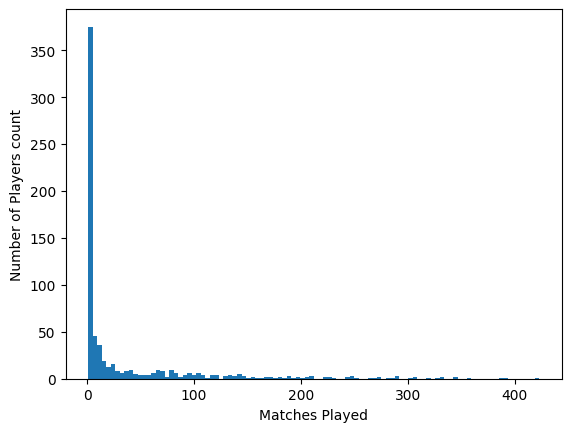

In [142]:
# Plot histogram of matches played
plt.hist(record['Total matches'], bins=100)
plt.ylabel('Number of Players count')
plt.xlabel('Matches Played')
plt.show() 

Let's remove these players from the main player stats dataframe as they're not part of the corpus that we're trying to built a predictive model for.

In [143]:
# list of player names who've played fewer than 5 times on the ATP tour in the given time period
sub_5_list = record_sub_5.to_list()

### Remove players with fewer than 5 games
p_df = p_df[~p_df['name'].isin(sub_5_list)]
p_df.shape

(26986, 27)

In [144]:
# Check we have data in all fields
p_df.isna().sum()

tourney_id       0
tourney_name     0
surface          0
draw_size        0
tourney_level    0
match_num        0
score            0
best_of          0
round            0
minutes          0
id               0
name             0
hand             0
ht               0
ioc              0
age              0
ace              0
df               0
svpt             0
1stIn            0
1stWon           0
2ndWon           0
SvGms            0
bpSaved          0
bpFaced          0
rank             0
rank points      0
dtype: int64

**Historical Statistics:**\
The raw data discussed above consists of observations that are collected from a given 
encounter, such as number of aces served or number of double faults. Since the goal of this 
project is to produce a predictive model for match outcomes ahead of time, these features are 
essentially useless in their given form – it is not possible to know of match specific features 
until after the match has finished by which time any notion of prediction is meaningless. To 
overcome this, averaged statistics were calculated for historic player ‘form’ before 
recombining with the Match and Tournament data to create the dataset. 
Match statistics were averaged for each player over a given window of games so that we could 
build up a notion of each player’s ‘form’ e.g. number of aces served per match in the x matches 
he/she played previous to the contest of interest.

***Feature Engineering***

Create historical feature averages (not including current match) and then merge them with the original dataframe to give a feature-class dataframe that can be used as an input to predictive models

In [145]:
### Add columns for serve data normalised per service point (necessary because some matches 3, some 5 sets)
for col in ['ace', 'df', '1stIn', '1stWon', '2ndWon', 'bpSaved', 'bpFaced']:
    p_df[col+'_per_svpt'] = p_df[col] / p_df['svpt']

### Calculate bp saved / faced proxy
p_df['bpSaved_per_bpFaced'] = p_df['bpSaved'] / (p_df['bpFaced']+1)

# Calculate rolling average of data over 'time_period' days

time_period = 30

p_df.sort_values(['MyDate', 'name'], inplace=True)

cols = p_df.columns[25:]
for name in cols:
    p_df['rolling_'+name] = p_df.groupby('name', sort=False)[name].shift().rolling(time_period, min_periods=1).mean().round(5)

# Create a dummy df to facillitate calculation of historical data for Player1 and Player2 and then merge the data with the original df.
df_test = p_df.loc[:, ['name', 'match_num', 'rolling_rank', 'rolling_rank points',
       'rolling_ace_per_svpt', 'rolling_df_per_svpt', 'rolling_1stIn_per_svpt',
       'rolling_1stWon_per_svpt', 'rolling_2ndWon_per_svpt',
       'rolling_bpSaved_per_svpt', 'rolling_bpFaced_per_svpt',
       'rolling_bpSaved_per_bpFaced']]

# Merge historical stats with original df
for i in ['Player1', 'Player2']:
    df = pd.merge(df.reset_index(), df_test.reset_index(),  how='inner', left_on=['tourney_date', i, 'match_num'], right_on=['MyDate', 'name', 'match_num'])

# Calculate differences in values of numerical features (Player1-Player2)
cols = ['rolling_rank', 'rolling_rank points',
       'rolling_ace_per_svpt', 'rolling_df_per_svpt', 'rolling_1stIn_per_svpt',
       'rolling_1stWon_per_svpt', 'rolling_2ndWon_per_svpt',
       'rolling_bpSaved_per_svpt', 'rolling_bpFaced_per_svpt',
       'rolling_bpSaved_per_bpFaced']

for col in cols:
    df[col+'_diff'] = df[col+'_x'] - df[col+'_y']

In [146]:
data_out = df.loc[:, ['flag', 'rolling_rank_diff',
       'rolling_rank points_diff', 'rolling_ace_per_svpt_diff',
       'rolling_df_per_svpt_diff', 'rolling_1stIn_per_svpt_diff',
       'rolling_1stWon_per_svpt_diff', 'rolling_2ndWon_per_svpt_diff',
       'rolling_bpSaved_per_svpt_diff', 'rolling_bpFaced_per_svpt_diff',
       'rolling_bpSaved_per_bpFaced_diff']]

**Add categorical variables...**

**Rank Calculation**

This system has a number of shortcomings: 
1. The rolling 52-week window assigns the same importance to matches played a year ago 
as to those played last week. 
2. The system is biased towards the better players - those that do well in prestigious 
tournaments earn more ranking points and so get allocated easier draws (through the 
seeding system) in future prestigious tournaments where they can then earn even more 
ranking points etc. This is one of the reasons that professional tennis is so hard to break 
into for young players. 
3. The number of points allocated at each stage of the ranking tournaments is arbitrary – 
a lower ranked player might have beaten Federer, Nadal and Djokovic to get to the 
Quarter final of a Masters 1000 event but will still earn half the ranking points (180 
versus 360) of someone who had an easier route to the same stage of a Grand Slam. 
4. The points allocated are the same irrespective of opponent i.e. if an up-and-coming 
young player overcomes Roger Federer in the Quarter Finals of the U.S. Open, he 
receives the same number of ranking points as he would have if he had beaten Richard 
Gasquet (an easier opponent).

In [147]:
from skelo.model.elo import EloEstimator

# Build Elo model from results

X = df.loc[:, ['tourney_date', 'Player1', 'Player2', 'flag']]
model = EloEstimator(
  key1_field="Player1",
  key2_field="Player2",
  timestamp_field="tourney_date",
  initial_time=np.datetime64('2010', 'Y'),
).fit(X, X["flag"])

ratings_est = model.rating_model.to_frame()
#ratings_est.groupby('key').mean('rating').sort_values('rating', ascending=False).head(5)

# Get rid of entries with valid_from = valid_to
ratings_est = ratings_est[ratings_est['valid_from'] != ratings_est['valid_to']]

# Merge into main df
for i in ['Player1', 'Player2']:
    
    df = pd.merge(df.reset_index(), 
                      ratings_est.reset_index(),  
                      how='inner', 
                      left_on=['tourney_date', i], 
                      right_on=['valid_from', 'key']).drop(columns=['valid_from', 'valid_to', 'index_x', 'index_y'])
    df = df.rename(columns={'key': i+'_key', 'rating': i+'_elo'})

df['Elo_diff'] = df['Player1_elo'] - df['Player2_elo']
df = df.drop(columns=['Player1_key', 'Player1_elo', 'Player2_key', 'Player2_elo'])



In [148]:
df.head()

,level_0,tourney_date,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_seed,...,rolling_rank points_diff,rolling_ace_per_svpt_diff,rolling_df_per_svpt_diff,rolling_1stIn_per_svpt_diff,rolling_1stWon_per_svpt_diff,rolling_2ndWon_per_svpt_diff,rolling_bpSaved_per_svpt_diff,rolling_bpFaced_per_svpt_diff,rolling_bpSaved_per_bpFaced_diff,Elo_diff
0,0,2010-01-03,2010-339,Brisbane,Hard,32,A,1,104053,1.0,...,760.50000,0.01423,0.01371,0.07728,0.08082,-0.05444,-0.02077,-0.01596,-0.27333,-57.200022
1,1,2010-01-03,2010-339,Brisbane,Hard,32,A,2,104958,NaN,...,1321.25000,0.02177,-0.02151,0.05423,0.04467,-0.02390,0.00738,0.00139,0.14623,10.575487
2,2,2010-01-03,2010-339,Brisbane,Hard,32,A,3,104755,NaN,...,425.25641,0.02513,-0.01549,0.00616,-0.00185,0.00823,0.00175,-0.00033,0.03552,-21.381048
3,3,2010-01-03,2010-339,Brisbane,Hard,32,A,4,105051,NaN,...,53.00000,-0.00196,0.00438,0.01586,0.02335,-0.01013,-0.00763,-0.00764,-0.10385,9.736601
4,4,2010-01-03,2010-339,Brisbane,Hard,32,A,5,104607,4.0,...,84.81818,0.02491,-0.00310,-0.02679,-0.00749,0.02392,-0.00412,-0.00722,-0.02693,-29.959924


<Axes: xlabel='valid_from'>

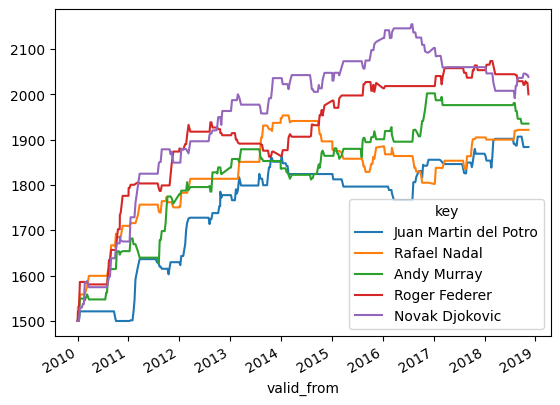

In [149]:
ts_est = ratings_est.pivot_table(index='valid_from', columns='key', values='rating').ffill()
idx = ts_est.iloc[-1].sort_values().index[-5:]
ts_est.loc[:, idx].plot()

**Some visuals to help take a look at what we have...**

In [150]:
data_out = df.loc[:, ['flag', 'rolling_rank_diff',
       'rolling_rank points_diff', 'rolling_ace_per_svpt_diff',
       'rolling_df_per_svpt_diff', 'rolling_1stIn_per_svpt_diff',
       'rolling_1stWon_per_svpt_diff', 'rolling_2ndWon_per_svpt_diff',
       'rolling_bpSaved_per_svpt_diff', 'rolling_bpFaced_per_svpt_diff',
       'rolling_bpSaved_per_bpFaced_diff', 'Elo_diff']]

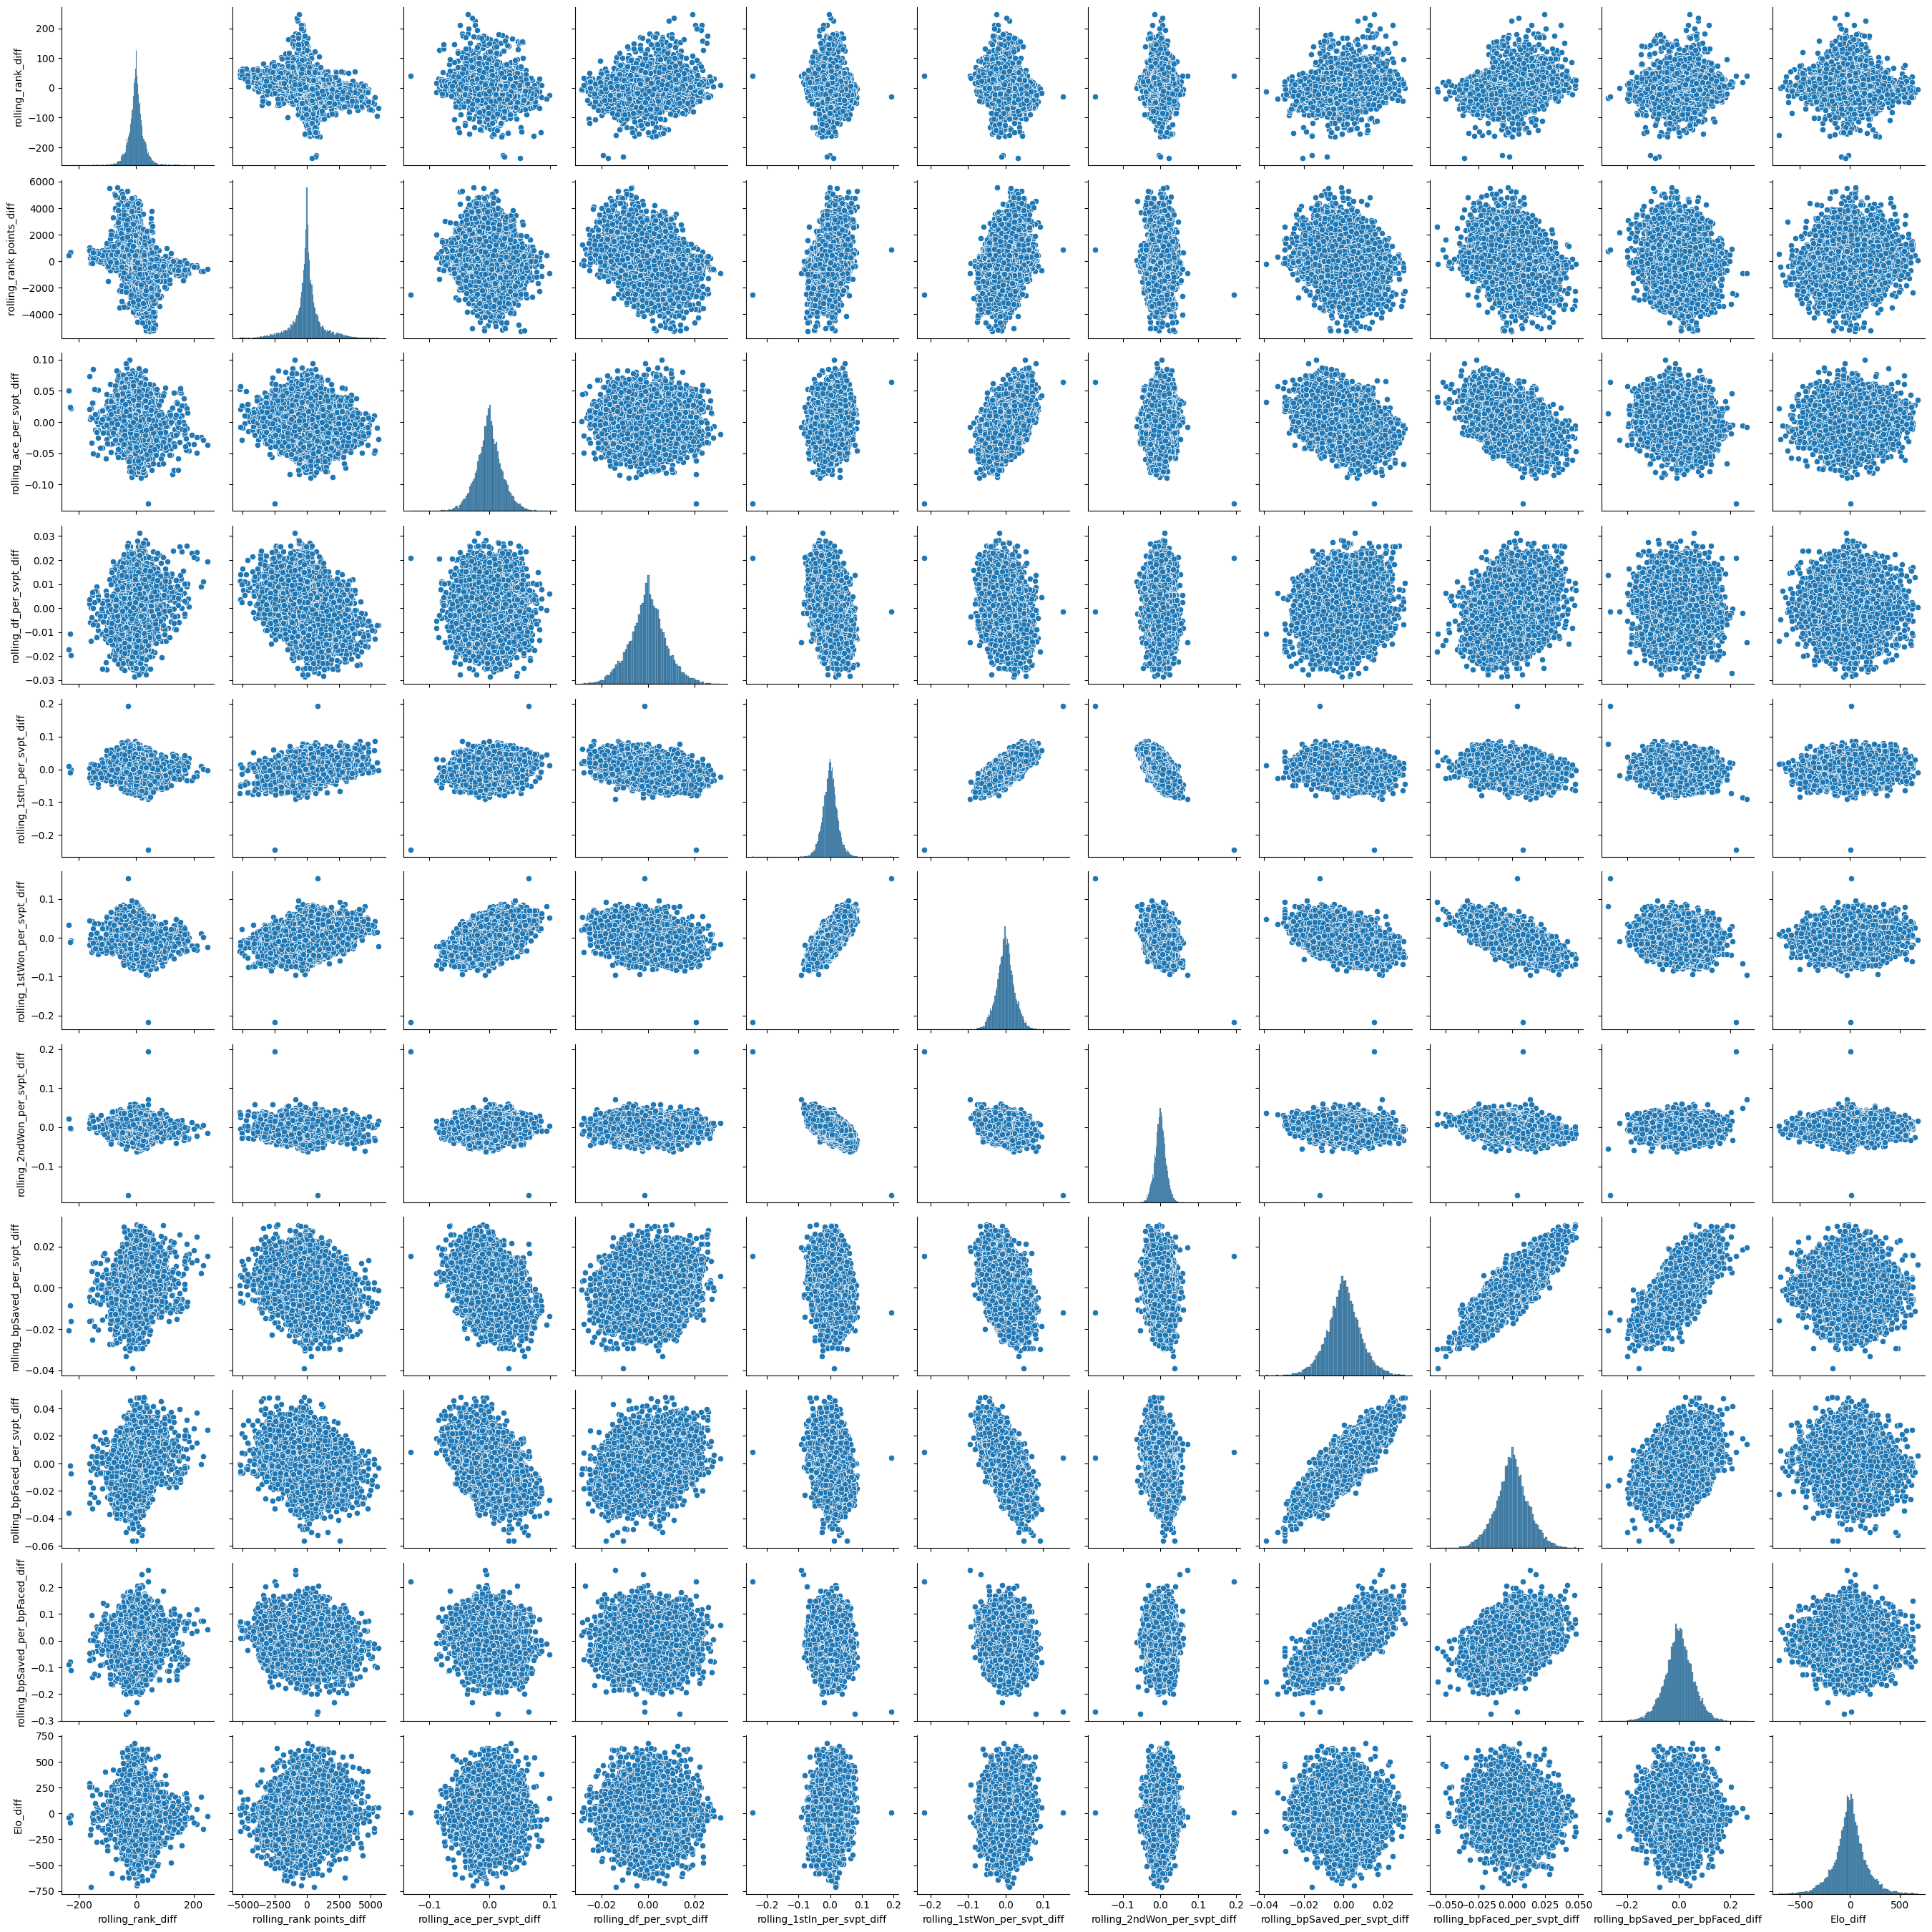

In [151]:
import seaborn as sns


num_var = ['rolling_rank_diff',
       'rolling_rank points_diff', 'rolling_ace_per_svpt_diff',
       'rolling_df_per_svpt_diff', 'rolling_1stIn_per_svpt_diff',
       'rolling_1stWon_per_svpt_diff', 'rolling_2ndWon_per_svpt_diff',
       'rolling_bpSaved_per_svpt_diff', 'rolling_bpFaced_per_svpt_diff',
       'rolling_bpSaved_per_bpFaced_diff', 'Elo_diff']
sns.pairplot(data_out[num_var], kind='scatter', diag_kind='hist')
plt.show()

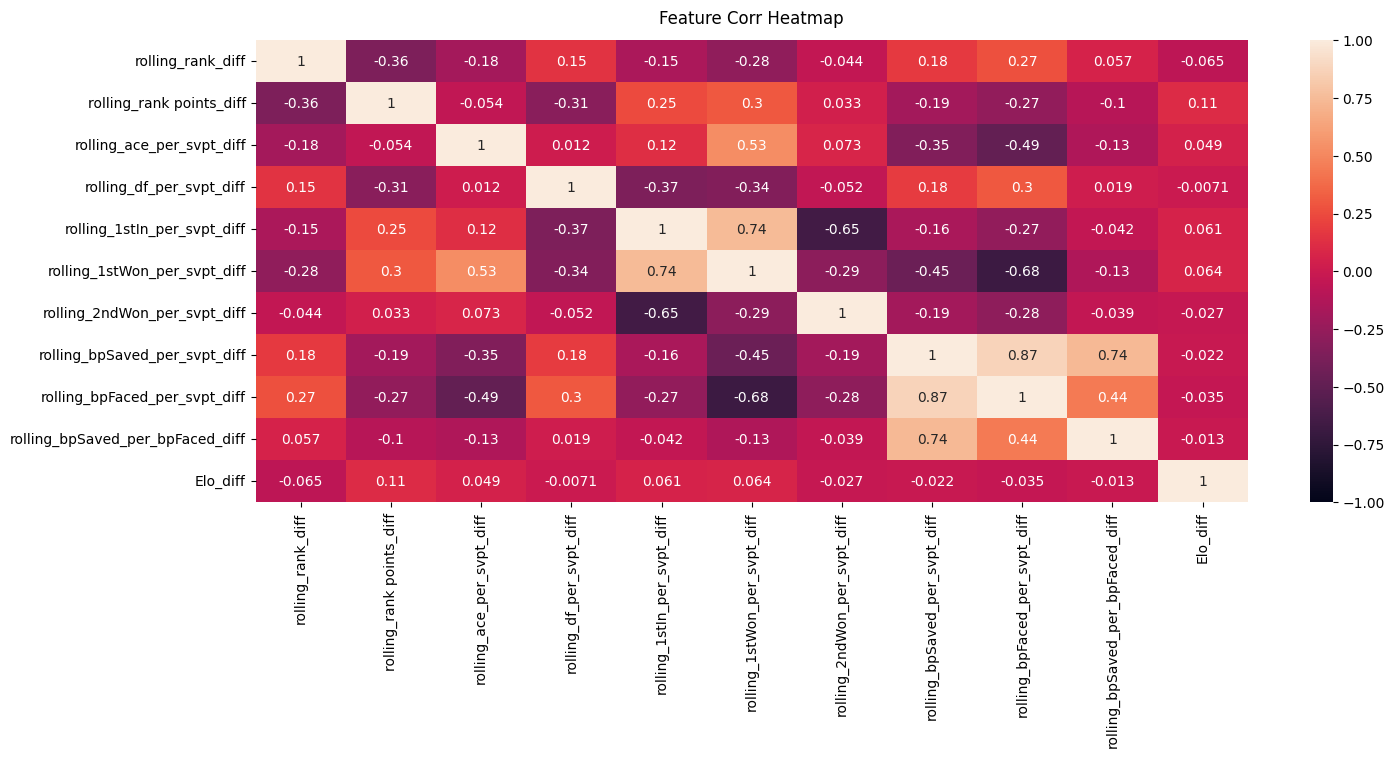

In [152]:
#sns.heatmap(data_out[num_var].corr());

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap((data_out[num_var].corr()), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Feature Corr Heatmap', fontdict={'fontsize':12}, pad=12);


In [153]:
# Save to file for further analysis...
data_out.to_csv('tennis.csv')